In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 3.3 MB/s eta 0:00:00


In [3]:
# Importing all necessary libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random
import numpy as np
import pandas as pd
from collections import defaultdict

In [4]:
class RoadNetwork:
    """
    Represents a road network loaded from OpenStreetMap using OSMnx.
    """
    def __init__(self, address, distance=1000, network_type='drive'):
        """
        Initializes the RoadNetwork with data from OSMnx.

        Args:
            address (str): Address to center the network around.
            distance (int, optional): Radius (in meters) around the address to load. Defaults to 1000.
            network_type (str, optional): Type of network to load (e.g., 'drive', 'walk'). Defaults to 'drive'.

        Raises:
            ValueError: If network cannot be loaded for the given address.
        """
        try:
            self.graph = ox.graph_from_address(address, dist=distance, network_type=network_type)

            # Check if graph is empty
            if len(self.graph.nodes) == 0:
                raise ValueError("Loaded network contains no nodes")
            if len(self.graph.edges) == 0:
                raise ValueError("Loaded network contains no edges")

            self._add_travel_time_attribute()
        except Exception as e:
            raise ValueError(f"Failed to load network for address '{address}': {str(e)}")

    def _add_travel_time_attribute(self):
        """
        Adds a 'travel_time' attribute to each edge based on speed limit and length.
        Handles different speed formats and units.

        Formula: travel_time (minutes) = length (meters) / (speed (km/h) * 1000/60)
        Where:
            - length is in meters
            - speed is in kilometers per hour
            - 1000/60 converts km/h to m/min
        """
        for u, v, k, data in self.graph.edges(data=True, keys=True):
            # Get maxspeed or default to 30 km/h
            speed = data.get("maxspeed", "30")

            # Handle list of speeds
            if isinstance(speed, list):
                speed = speed[0]

            # Clean and convert speed value
            speed_value = 30.0  # Default value

            if isinstance(speed, str):
                # Extract numeric part and unit
                speed_parts = speed.strip().split()
                speed_num = speed_parts[0]
                try:
                    speed_value = float(speed_num)

                    # Convert mph to km/h if necessary
                    if len(speed_parts) > 1 and "mph" in speed_parts[1].lower():
                        speed_value *= 1.60934  # Convert mph to km/h
                except (ValueError, TypeError):
                    print(f"Warning: Could not parse speed value '{speed}', using default of 30 km/h")
            elif isinstance(speed, (int, float)):
                speed_value = float(speed)

            # Calculate travel time (in minutes) with explicit unit conversion
            length_m = data["length"]  # length in meters
            speed_kmh = speed_value    # speed in km/h
            meters_per_minute = (speed_kmh * 1000) / 60  # Convert km/h to m/min
            data["travel_time"] = length_m / meters_per_minute  # Result in minutes

            # Calculate road capacity based on road properties
            lanes = data.get("lanes", 1)
            if isinstance(lanes, list):
                lanes = lanes[0]
            try:
                lanes = float(lanes)
            except (ValueError, TypeError):
                lanes = 1.0

            road_type = data.get("highway", "residential")
            # Base capacity depends on road type
            if road_type in ["motorway", "trunk", "primary"]:
                base_capacity = 25  # Higher capacity for major roads
            elif road_type in ["secondary", "tertiary"]:
                base_capacity = 15  # Medium capacity
            else:
                base_capacity = 8   # Lower capacity for minor roads

            data["capacity"] = base_capacity * lanes

    def plot(self):
        """
        Plots the road network using OSMnx.

        Returns:
            tuple: Figure and Axes objects of the plot.
        """
        fig, ax = ox.plot_graph(self.graph, figsize=(10,10))
        return fig, ax

In [5]:
class Car:
    """
    Represents a car in the traffic simulation.
    """
    def __init__(self, start, destination, graph=None):
        """
        Initializes the Car with a start and destination node.

        Args:
            start (int): Node ID of the starting location.
            destination (int): Node ID of the destination location.
            graph (networkx.MultiDiGraph, optional): The road network graph.

        Attributes:
            current_location (int): Current node ID where the car is located.
            destination (int): Target node ID where the car is heading.
            path (list): Ordered list of node IDs representing the planned route,
                        excluding the current location (first node is the next node to visit).
            graph (networkx.MultiDiGraph, optional): Reference to the road network graph.
        """
        if graph is not None:
        # Validate nodes exist in graph
          if start not in graph:
              raise ValueError(f"Start node {start} does not exist in the graph")
          if destination not in graph:
              raise ValueError(f"Destination node {destination} does not exist in the graph")

        self.current_location = start
        self.destination = destination
        self.path = []
        self.graph = graph # Reference to the graph

        # Initialize path if graph is provided
        if graph is not None:
            self.calculate_path(graph)

    def calculate_path(self, graph):
        """
        Calculates the shortest path from current location to destination.

        Args:
            graph (networkx.MultiDiGraph): The road network graph.

        Returns:
            bool: True if path was found, False otherwise.
        """
        try:
            import networkx as nx
            full_path = nx.shortest_path(graph, self.current_location, self.destination, weight="travel_time")
            self.path = full_path[1:]  # Exclude current location
            return True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False

    def recalculate_path_with_congestion(self, graph, congestion_map, congestion_threshold=0.7): # Corrected indentation
      """
      Recalculates path avoiding congested roads.
      """
      import networkx as nx

      # Create a copy of the graph with congestion weights
      G_temp = graph.copy()

      # Apply congestion penalties to edge weights
      for u, v, k, data in G_temp.edges(data=True, keys=True):
          congestion = congestion_map.get((u, v, k), 0)
          if congestion > congestion_threshold:
              # Penalize congested roads by increasing travel time
              congestion_penalty = 1 + (congestion * 5)  # Up to 6x longer
              G_temp[u][v][k]["travel_time_adjusted"] = data["travel_time"] * congestion_penalty
          else:
              G_temp[u][v][k]["travel_time_adjusted"] = data["travel_time"]

      try:
          # Find path with adjusted weights
          return nx.shortest_path(G_temp, self.current_location, self.destination,
                                 weight="travel_time_adjusted")
      except (nx.NetworkXNoPath, nx.NodeNotFound):
          # Fall back to original path if no alternative found
          return nx.shortest_path(graph, self.current_location, self.destination,
                                 weight="travel_time")

In [6]:
class TrafficSimulator:
    """
    Simulates traffic flow on a road network.
    """
    def __init__(self, road_network, num_cars=100, start_hour = 8):
        """
        Initializes the TrafficSimulator with a road network and number of cars.

        Args:
            road_network (RoadNetwork): The road network to simulate on.
            num_cars (int, optional): Number of cars in the simulation. Defaults to 100.
        """
        self.road_network = road_network
        self.num_cars = num_cars
        self.cars = self._create_cars()
        self.current_hour = start_hour
        self.minutes = 0
        self.minutes_per_step = 1 # Define minutes_per_step (I decided to set at 1 as it gave interesting results)
        self.congestion_map = {}

    def _create_cars(self):
      """
      Creates cars with random starting and destination locations.
      Initializes their paths using the road network.
      """
      nodes = list(self.road_network.graph.nodes())
      cars = []

      for _ in range(self.num_cars):
          start = random.choice(nodes)
          destination = random.choice([n for n in nodes if n != start])
          car = Car(start, destination, self.road_network.graph)
        # Ensure car has a valid path
          if not car.path and car.current_location != car.destination:
              try:
                  car.path = nx.shortest_path(self.road_network.graph,
                                              car.current_location,
                                              car.destination,
                                              weight="travel_time")[1:]  # Exclude current location
              except nx.NetworkXNoPath:
                  # Try a different destination
                  continue
          cars.append(car)

      return cars

    def move_cars(self):
      """
      Moves cars in the simulation based on their paths and traffic conditions.
      """
    # Update congestion map periodically
      if not hasattr(self, 'step_counter'):
          self.step_counter = 0
      self.step_counter += 1

      if self.step_counter % 5 == 0:
          self.update_congestion_map()

      # Track if any car moved for debugging
      any_car_moved = False

      for car in self.cars:
        # Check if car has reached its destination
        if car.current_location == car.destination:
            # Generate a new destination
            nodes = list(self.road_network.graph.nodes())
            car.destination = random.choice([node for node in nodes if node != car.current_location])
            try:
                car.path = nx.shortest_path(self.road_network.graph,
                                          car.current_location,
                                          car.destination,
                                          weight="travel_time")[1:]  # Exclude current location
            except nx.NetworkXNoPath:
                continue  # Skip this car if no path found
           # print(f"Car reached destination, new path length: {len(car.path)}")
            continue

        # Skip cars with empty paths
        if not car.path:
            # Try to recalculate path
            try:
                car.path = nx.shortest_path(self.road_network.graph,
                                          car.current_location,
                                          car.destination,
                                          weight="travel_time")[1:]
                #print(f"Recalculated path, new length: {len(car.path)}")
            except nx.NetworkXNoPath:
                # If no path, assign new destination
                nodes = list(self.road_network.graph.nodes())
                car.destination = random.choice([node for node in nodes if node != car.current_location])
                try:
                    car.path = nx.shortest_path(self.road_network.graph,
                                              car.current_location,
                                              car.destination,
                                              weight="travel_time")[1:]
                   # print(f"New destination, path length: {len(car.path)}")
                except nx.NetworkXNoPath:
                    continue

            if not car.path:
                continue

        next_node = car.path[0]

        # Check if the edge exists (in case the graph changed)
        if next_node not in self.road_network.graph[car.current_location]:
            # Path is invalid, recalculate
            try:
                car.path = nx.shortest_path(self.road_network.graph,
                                          car.current_location,
                                          car.destination,
                                          weight="travel_time")[1:]
            except nx.NetworkXNoPath:
                continue
            if not car.path:
                continue
            next_node = car.path[0]

        # Find the edge data
        edge_data = None
        for k in self.road_network.graph[car.current_location][next_node]:
            edge_data = self.road_network.graph[car.current_location][next_node][k]
            break

        # Count cars on edge
        cars_on_edge = sum(1 for c in self.cars if c.current_location == car.current_location and c.path and c.path[0] == next_node)

        # Calculate movement probability based on congestion
        capacity = edge_data.get('capacity', 8)

        # Apply time factors
        time_factor = 1.0
        if 7 <= self.current_hour <= 9 or 16 <= self.current_hour <= 18: # RUsh hour
            time_factor = 0.6

        effective_capacity = capacity * time_factor
        congestion_factor = min(1.0, cars_on_edge / effective_capacity)
        speed_reduction = 1.0 - (congestion_factor * 0.8)

        # ONLY ONE movement decision per car per step
        if random.random() < speed_reduction:
            car.current_location = next_node
            car.path.pop(0)
            any_car_moved = True

        # Dynamic rerouting (separate from movement)
        reroute_probability = 0.05
        if congestion_factor > 0.7:
            reroute_probability = 0.3

        if random.random() < reroute_probability and hasattr(car, 'recalculate_path_with_congestion'):
            try:
                new_path = car.recalculate_path_with_congestion(
                    self.road_network.graph,
                    self.congestion_map
                )
                if new_path and len(new_path) > 1:
                    car.path = new_path[1:]
            except Exception as e:
                print(f"Error in rerouting: {e}")

      if not any_car_moved:
        print("WARNING: No cars moved this step!")

    def simulate(self, num_steps=10):
        """
        Runs the traffic simulation for a given number of steps.

        Args:
            num_steps (int, optional): Number of simulation steps. Defaults to 10.
        """
        for step in range(num_steps):
          # Update simulation time
          self.minutes += self.minutes_per_step
          if self.minutes >= 60:
            self.current_hour += (self.current_hour + 1) % 24
            self.minutes %= 60

          # Move cars - this MUST be properly indented to run every step
          self.move_cars()
          #print(f"Step {step + 1} - Time: {self.current_hour:02d}:{self.minutes:02d}")

          # Check if anything is happening
          car_moved = False
          for car in self.cars:
              if car.path:
                  car_moved = True
                  break

          if not car_moved:
              print("WARNING: No cars are moving in the simulation!")

            # For demonstration, print the number of cars at each node
          """
          node_counts = {node: 0 for node in self.road_network.graph.nodes()}
          for car in self.cars:
                node_counts[car.current_location] += 1
          print(f"Step {step + 1}:")
          for node, count in node_counts.items():
                print(f"Node {node}: {count} cars")
          print()
          """

    def plot_traffic(self):
        """
        Improved traffic visualization using congestion (cars / capacity).
        Adds colorbar and better styling.
        """
        # Update congestion map before plotting
        self.update_congestion_map()
        G = self.road_network.graph

        # Get node positions for layout
        node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

        # Boost low congestion values
        congestion_boost = {k: v**0.5 for k, v in self.congestion_map.items()}  # gamma correction
        max_congestion = max(congestion_boost.values()) if congestion_boost else 1
        norm = mcolors.Normalize(vmin=0, vmax=max(congestion_boost.values()))
        cmap = cm.get_cmap("OrRd")

        fig, ax = plt.subplots(figsize=(10, 10))
        fig.patch.set_facecolor('lightgray')     # Set figure background
        ax.set_facecolor('lightgray')            # Set plot (axes) background

        for (u, v, k), congestion in self.congestion_map.items():
            color = cmap(norm(congestion))
            width = 2 + 4 * congestion  # line thickness increases with congestion

            x_vals = [node_positions[u][0], node_positions[v][0]]
            y_vals = [node_positions[u][1], node_positions[v][1]]
            ax.plot(x_vals, y_vals, color=color, linewidth=width, alpha=0.9)

        # Draw nodes
        nx.draw_networkx_nodes(G, node_positions, ax=ax, node_size=5, node_color="gray", alpha = 0.7)

        # Colorbar legend
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.7, pad=0.01)
        cbar.set_label("Congestion Level (cars / capacity)", fontsize=12)
        # Add ticks with readable values
        cbar_ticks = np.linspace(0, max(congestion_boost.values()), num=6)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels([f"{tick:.2f}" for tick in cbar_ticks])
        cbar.ax.yaxis.set_tick_params(color='black', labelcolor='black')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

        ax.set_title("Traffic Congestion Map", fontsize=15, color="black")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, colors = 'white')
        plt.axis("off")
        plt.show()

        return fig, ax

    def _edge_car_counts(self):
        """
        Calculates the number of cars on each edge of the road network.

        Returns:
            dict: A dictionary mapping edge keys (u, v, k) to car counts.
        """
        counts = {}
        for u, v, k in self.road_network.graph.edges(keys=True):
            counts[(u, v, k)] = 0 # Using u, v, k as key

        for car in self.cars:
            if car.path:
                next_node = car.path[0]
                # Find the correct edge key
                for k in self.road_network.graph[car.current_location][next_node].keys():
                    counts[(car.current_location, next_node, k)] += 1
                    break  # Assuming we only want to count one edge between the nodes
        return counts

    def update_congestion_map(self):
      """
      Creates a map of congested edges in the network.
      """
      self.congestion_map = {}

    # Calculate congestion for each edge
      for u, v, k, data in self.road_network.graph.edges(data=True, keys=True):
        cars_on_edge = sum(1 for car in self.cars
                            if car.current_location == u
                            and car.path
                            and car.path[0] == v)
        capacity = data.get('capacity', 8) # Get capacity from edge data
        congestion_level = cars_on_edge / capacity
        self.congestion_map[(u, v, k)] = congestion_level

<ipython-input-6-5b8c658043ff>:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("OrRd")


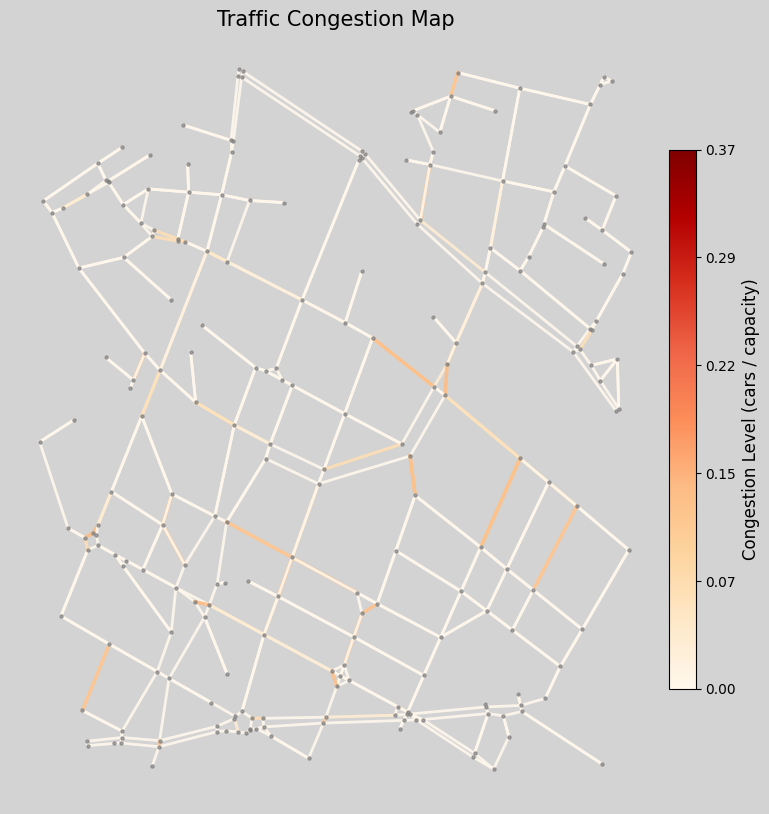

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Traffic Congestion Map'}>)

In [7]:
berlin_network = RoadNetwork('Adalbertstraße 58, Berlin, Germany')
simulator = TrafficSimulator(berlin_network)
simulator.simulate()
simulator.plot_traffic()

{(21487224, 29215073, 0): np.float64(0.006666666666666666),
 (21487224, 196725581, 0): np.float64(0.003333333333333333),
 (21487230, 26960762, 0): np.float64(0.003333333333333333),
 (21487230, 28794539, 0): np.float64(0.0),
 (21487230, 196724115, 0): np.float64(0.006666666666666666),
 (21487230, 1491865195, 0): np.float64(0.0),
 (21487231, 29215047, 0): np.float64(0.013333333333333332),
 (21487231, 5984003368, 0): np.float64(0.0),
 (21487232, 26960762, 0): np.float64(0.006666666666666666),
 (21487232, 29218293, 0): np.float64(0.02),
 (21487232, 29218315, 0): np.float64(0.01),
 (21487232, 269476782, 0): np.float64(0.0044444444444444444),
 (26517409, 287447548, 0): np.float64(0.0022222222222222222),
 (26960758, 29271261, 0): np.float64(0.006666666666666666),
 (26960761, 28794542, 0): np.float64(0.019999999999999997),
 (26960761, 29218316, 0): np.float64(0.0125),
 (26960761, 2625899861, 0): np.float64(0.02),
 (26960761, 3411530669, 0): np.float64(0.006666666666666666),
 (26960762, 2148723

<ipython-input-6-5b8c658043ff>:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("OrRd")


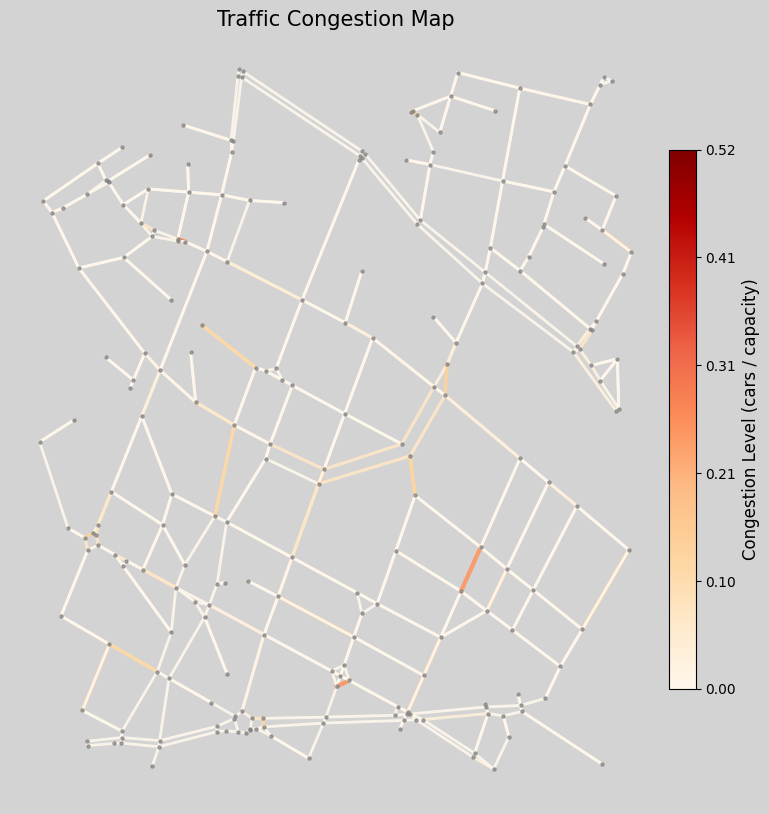

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Traffic Congestion Map'}>)

In [10]:
## Simulating Berlin network for 10 times
# a. Empirical Analysis
num_simulations = 10  # Number of simulations to run
congestion_data = []  # Store congestion levels for each simulation

for _ in range(num_simulations):
    simulator = TrafficSimulator(berlin_network)
    simulator.simulate(num_steps=100) # Run simulation for 100 steps in each loop
    congestion_data.append(simulator.congestion_map)

# Analyze congestion_data to identify consistently congested edges
# For example, calculate average congestion for each edge:
edge_congestion_avg = {}
for edge in berlin_network.graph.edges(keys=True):
    edge_congestion_avg[edge] = np.mean([d.get(edge, 0) for d in congestion_data])

# Print the most congested edges
# This will show which edges are most congested across simulations
import pprint
pprint.pprint(edge_congestion_avg)

simulator.plot_traffic()

In [15]:
## Theoretical Analysis
betweenness_centrality = nx.betweenness_centrality(berlin_network.graph, weight="travel_time")
edge_betweenness_centrality = nx.edge_betweenness_centrality(berlin_network.graph, weight="travel_time")
closeness_centrality = nx.closeness_centrality(berlin_network.graph, distance="travel_time")
degree_centrality = nx.degree_centrality(berlin_network.graph)
print(f"Between centrality:", betweenness_centrality)
print(f"Edge between centrality:", edge_betweenness_centrality)
print(f"Closeness centrality:", closeness_centrality)
print(f"Degree centrality:", degree_centrality)

Between centrality: {21487224: 0.020275319567354965, 21487230: 0.0535889872173058, 21487231: 0.04232055063913471, 21487232: 0.23089478859390364, 26517409: 0.008770894788593903, 26960758: 0.03710914454277286, 26960761: 0.20214355948869223, 26960762: 0.27058013765978367, 27555211: 0.0, 27555214: 0.008180924287118977, 27555215: 0.012684365781710914, 27555221: 0.030285152409046213, 27555224: 0.022241887905604718, 27555225: 0.013254670599803344, 27555226: 0.0003343166175024582, 27555227: 0.012920353982300885, 28373648: 0.025034414945919372, 28373656: 0.1377384464110128, 28794517: 0.008810226155358898, 28794518: 0.025152409046214356, 28794519: 0.0696558505408063, 28794539: 0.008790560471976402, 28794542: 0.18200589970501474, 29215046: 0.13390363815142575, 29215047: 0.09634218289085546, 29215049: 0.14271386430678465, 29215057: 0.025801376597836774, 29215058: 0.017718780727630286, 29215060: 0.00031465093411996067, 29215063: 0.0, 29215067: 0.012546705998033432, 29215071: 0.0, 29215073: 0.026234

<ipython-input-6-5b8c658043ff>:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("OrRd")


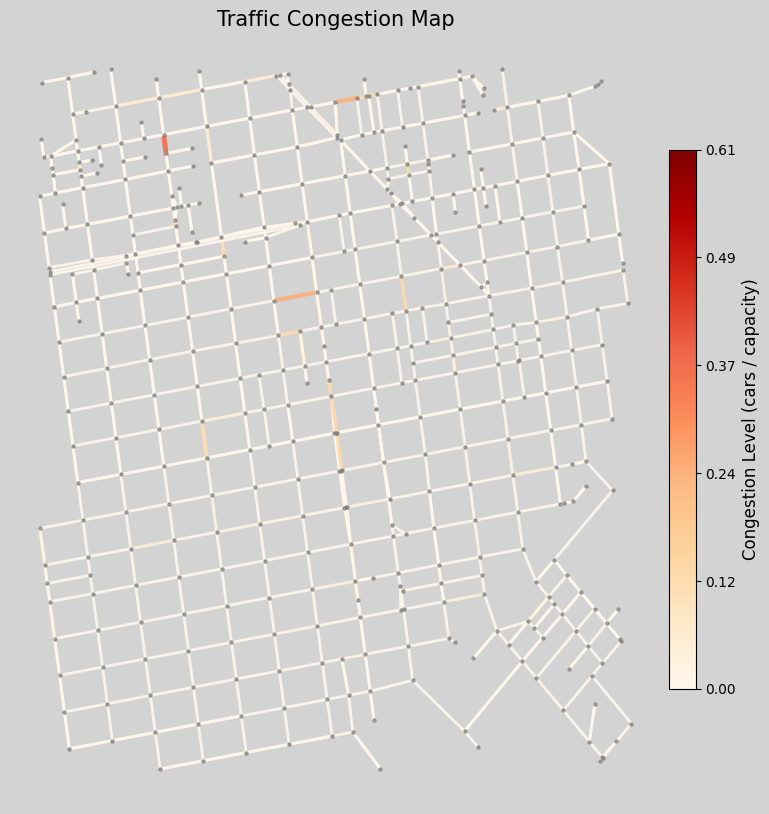

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Traffic Congestion Map'}>)

In [17]:
### My address in SF
sf_network = RoadNetwork('California 851, San Francisco, United States')
simulator = TrafficSimulator(sf_network)
simulator.simulate(num_steps = 100)
simulator.plot_traffic()